In [6]:
import h5py
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle
import time

In [ ]:
# Importing necessary modules from MEDFAIR repository
import sys
sys.path.append('/path/to/MEDFAIR')  # Update this with the actual path to MEDFAIR repository
from models import *  # Update this to specific models if needed


## Preprocess metadata

In [17]:
# read metadata
path = '/Users/amir/PycharmProjects/Medfair/MEDFAIR/'

demo_data = pd.read_excel(path + 'BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx')
demo_data

,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Echogenicity,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification
0,1,case001.png,case001_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,...,heterogeneous,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),2,confirmed by follow-up care,not applicable,benign
1,2,case002.png,case002_tumor.png,NaN,0.006462,NaN,homogeneous: fat,not available,not available,oval,...,hypoechoic,no,no,no,no,Dysplasia&Fibroadenoma,4b,confirmed by biopsy,Intramammary lymph node,benign
2,3,case003.png,case003_tumor.png,NaN,0.006944,56.0,heterogeneous: predominantly fat,no,nipple discharge,oval,...,hyperechoic,no,no,no,no,Duct filled with thick fluid&Intraductal papil...,4a,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,benign
3,4,case004.png,case004_tumor.png,NaN,0.007812,43.0,homogeneous: fibroglandular,no,no,round,...,hypoechoic,no,no,no,no,Cyst filled with thick fluid,3,confirmed by follow-up care,not applicable,benign
4,5,case005.png,case005_tumor.png,NaN,0.007812,67.0,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,...,complex cystic/solid,enhancement,no,no,no,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,malignant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,case252.png,case252_tumor.png,NaN,0.006944,18.0,homogeneous: fibroglandular,palpable,no,oval,...,hypoechoic,no,no,no,no,Fibroadenoma,4a,confirmed by biopsy,Fibroadenoma,benign
252,253,case253.png,case253_tumor.png,NaN,0.007812,64.0,homogeneous: fat,palpable&breast scar,family history of breast/ovarian cancer,oval,...,anechoic,enhancement,no,no,yes,Fat necrosis&Breast scar (surgery),2,confirmed by follow-up care,not applicable,benign
253,254,case254.png,case254_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,no,no,irregular,...,hypoechoic,shadowing,no,no,no,Suspicion of malignancy,5,confirmed by biopsy,Invasive carcinoma of no special type (NST)&Du...,malignant
254,255,case255.png,case255_tumor.png,NaN,0.006944,42.0,heterogeneous: predominantly fibroglandular,palpable,family history of breast/ovarian cancer,irregular,...,heterogeneous,shadowing,no,intraductal,no,Suspicion of malignancy&Mastitis,4c,confirmed by biopsy,Ductal carcinoma in situ (DCIS),malignant


In [18]:
Counter(demo_data['CaseID'])

Counter({1: 1,
         2: 1,
         3: 1,
         4: 1,
         5: 1,
         6: 1,
         7: 1,
         8: 1,
         9: 1,
         10: 1,
         11: 1,
         12: 1,
         13: 1,
         14: 1,
         15: 1,
         16: 1,
         17: 1,
         18: 1,
         19: 1,
         20: 1,
         21: 1,
         22: 1,
         23: 1,
         24: 1,
         25: 1,
         26: 1,
         27: 1,
         28: 1,
         29: 1,
         30: 1,
         31: 1,
         32: 1,
         33: 1,
         34: 1,
         35: 1,
         36: 1,
         37: 1,
         38: 1,
         39: 1,
         40: 1,
         41: 1,
         42: 1,
         43: 1,
         44: 1,
         45: 1,
         46: 1,
         47: 1,
         48: 1,
         49: 1,
         50: 1,
         51: 1,
         52: 1,
         53: 1,
         54: 1,
         55: 1,
         56: 1,
         57: 1,
         58: 1,
         59: 1,
         60: 1,
         61: 1,
         62: 1,
         63: 1,
 

In [19]:
# add image path to the metadata
pathlist = demo_data['Image_filename'].values.tolist()
paths = ['/Users/amir/PycharmProjects/Medfair/MEDFAIR/BrEaST-Lesions_USG-images_and_masks/' + i + '.jpg' for i in pathlist]
demo_data['Path'] = paths

In [20]:
# remove age/sex == null 
demo_data = demo_data[~demo_data['Age'].isnull()]
# demo_data = demo_data[~demo_data['sex'].isnull()]
demo_data

,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification,Path
0,1,case001.png,case001_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,...,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),2,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
2,3,case003.png,case003_tumor.png,NaN,0.006944,56.0,heterogeneous: predominantly fat,no,nipple discharge,oval,...,no,no,no,no,Duct filled with thick fluid&Intraductal papil...,4a,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
3,4,case004.png,case004_tumor.png,NaN,0.007812,43.0,homogeneous: fibroglandular,no,no,round,...,no,no,no,no,Cyst filled with thick fluid,3,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
4,5,case005.png,case005_tumor.png,NaN,0.007812,67.0,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,...,enhancement,no,no,no,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
5,6,case006.png,case006_tumor.png,NaN,0.007812,56.0,heterogeneous: predominantly fat,no,HRT/hormonal contraception,irregular,...,no,no,intraductal,no,Suspicion of malignancy&Intraductal papilloma&...,4b,confirmed by biopsy,Fibrosclerosis,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,case252.png,case252_tumor.png,NaN,0.006944,18.0,homogeneous: fibroglandular,palpable,no,oval,...,no,no,no,no,Fibroadenoma,4a,confirmed by biopsy,Fibroadenoma,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
252,253,case253.png,case253_tumor.png,NaN,0.007812,64.0,homogeneous: fat,palpable&breast scar,family history of breast/ovarian cancer,oval,...,enhancement,no,no,yes,Fat necrosis&Breast scar (surgery),2,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
253,254,case254.png,case254_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,no,no,irregular,...,shadowing,no,no,no,Suspicion of malignancy,5,confirmed by biopsy,Invasive carcinoma of no special type (NST)&Du...,malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...
254,255,case255.png,case255_tumor.png,NaN,0.006944,42.0,heterogeneous: predominantly fibroglandular,palpable,family history of breast/ovarian cancer,irregular,...,shadowing,no,intraductal,no,Suspicion of malignancy&Mastitis,4c,confirmed by biopsy,Ductal carcinoma in situ (DCIS),malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...


In [ ]:
# unify the value of sensitive attributes
# sex = demo_data['sex'].values
# sex[sex == 'male'] = 'M'
# sex[sex == 'female'] = 'F'
# demo_data['Sex'] = sex
# demo_data

In [21]:
# split subjects to different age groups
demo_data['Age_multi'] = demo_data['Age'].values.astype('int')
demo_data['Age_multi'] = np.where(demo_data['Age_multi'].between(-1,19), 0, demo_data['Age_multi'])
demo_data['Age_multi'] = np.where(demo_data['Age_multi'].between(20,39), 1, demo_data['Age_multi'])
demo_data['Age_multi'] = np.where(demo_data['Age_multi'].between(40,59), 2, demo_data['Age_multi'])
demo_data['Age_multi'] = np.where(demo_data['Age_multi'].between(60,79), 3, demo_data['Age_multi'])
demo_data['Age_multi'] = np.where(demo_data['Age_multi']>=80, 4, demo_data['Age_multi'])

demo_data['Age_binary'] = demo_data['Age'].values.astype('int')
demo_data['Age_binary'] = np.where(demo_data['Age_binary'].between(-1, 60), 0, demo_data['Age_binary'])
demo_data['Age_binary'] = np.where(demo_data['Age_binary']>= 60, 1, demo_data['Age_binary'])
demo_data

/var/folders/nn/fgf_xpts7y18yb4cb3hx57k80000gn/T/ipykernel_21245/2237739249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_data['Age_multi'] = demo_data['Age'].values.astype('int')
/var/folders/nn/fgf_xpts7y18yb4cb3hx57k80000gn/T/ipykernel_21245/2237739249.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_data['Age_multi'] = np.where(demo_data['Age_multi'].between(-1,19), 0, demo_data['Age_multi'])
/var/folders/nn/fgf_xpts7y18yb4cb3hx57k80000gn/T/ipykernel_21245/2237739249.py:4: SettingWith

,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Calcifications,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification,Path,Age_multi,Age_binary
0,1,case001.png,case001_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,...,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),2,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,2,0
2,3,case003.png,case003_tumor.png,NaN,0.006944,56.0,heterogeneous: predominantly fat,no,nipple discharge,oval,...,no,no,Duct filled with thick fluid&Intraductal papil...,4a,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,2,0
3,4,case004.png,case004_tumor.png,NaN,0.007812,43.0,homogeneous: fibroglandular,no,no,round,...,no,no,Cyst filled with thick fluid,3,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,2,0
4,5,case005.png,case005_tumor.png,NaN,0.007812,67.0,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,...,no,no,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,3,1
5,6,case006.png,case006_tumor.png,NaN,0.007812,56.0,heterogeneous: predominantly fat,no,HRT/hormonal contraception,irregular,...,intraductal,no,Suspicion of malignancy&Intraductal papilloma&...,4b,confirmed by biopsy,Fibrosclerosis,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,case252.png,case252_tumor.png,NaN,0.006944,18.0,homogeneous: fibroglandular,palpable,no,oval,...,no,no,Fibroadenoma,4a,confirmed by biopsy,Fibroadenoma,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,0,0
252,253,case253.png,case253_tumor.png,NaN,0.007812,64.0,homogeneous: fat,palpable&breast scar,family history of breast/ovarian cancer,oval,...,no,yes,Fat necrosis&Breast scar (surgery),2,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,3,1
253,254,case254.png,case254_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,no,no,irregular,...,no,no,Suspicion of malignancy,5,confirmed by biopsy,Invasive carcinoma of no special type (NST)&Du...,malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,2,0
254,255,case255.png,case255_tumor.png,NaN,0.006944,42.0,heterogeneous: predominantly fibroglandular,palpable,family history of breast/ovarian cancer,irregular,...,intraductal,no,Suspicion of malignancy&Mastitis,4c,confirmed by biopsy,Ductal carcinoma in situ (DCIS),malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,2,0


In [23]:
# convert to binary labels
# benign: bcc, bkl, dermatofibroma, nv, vasc
# maglinant: akiec, mel

labels = demo_data['Classification'].values.copy()
labels[labels == 'malignant'] = '1'
labels[labels != '1'] = '0'

labels = labels.astype('int')

demo_data['binaryLabel'] = labels
demo_data

/var/folders/nn/fgf_xpts7y18yb4cb3hx57k80000gn/T/ipykernel_21245/2248072005.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_data['binaryLabel'] = labels


,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification,Path,Age_multi,Age_binary,binaryLabel
0,1,case001.png,case001_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,...,yes,Breast scar (surgery)&Breast scar (radiotherapy),2,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,2,0,0
2,3,case003.png,case003_tumor.png,NaN,0.006944,56.0,heterogeneous: predominantly fat,no,nipple discharge,oval,...,no,Duct filled with thick fluid&Intraductal papil...,4a,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,2,0,0
3,4,case004.png,case004_tumor.png,NaN,0.007812,43.0,homogeneous: fibroglandular,no,no,round,...,no,Cyst filled with thick fluid,3,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,2,0,0
4,5,case005.png,case005_tumor.png,NaN,0.007812,67.0,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,...,no,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,3,1,1
5,6,case006.png,case006_tumor.png,NaN,0.007812,56.0,heterogeneous: predominantly fat,no,HRT/hormonal contraception,irregular,...,no,Suspicion of malignancy&Intraductal papilloma&...,4b,confirmed by biopsy,Fibrosclerosis,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,case252.png,case252_tumor.png,NaN,0.006944,18.0,homogeneous: fibroglandular,palpable,no,oval,...,no,Fibroadenoma,4a,confirmed by biopsy,Fibroadenoma,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,0,0,0
252,253,case253.png,case253_tumor.png,NaN,0.007812,64.0,homogeneous: fat,palpable&breast scar,family history of breast/ovarian cancer,oval,...,yes,Fat necrosis&Breast scar (surgery),2,confirmed by follow-up care,not applicable,benign,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,3,1,0
253,254,case254.png,case254_tumor.png,NaN,0.007812,57.0,heterogeneous: predominantly fat,no,no,irregular,...,no,Suspicion of malignancy,5,confirmed by biopsy,Invasive carcinoma of no special type (NST)&Du...,malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,2,0,1
254,255,case255.png,case255_tumor.png,NaN,0.006944,42.0,heterogeneous: predominantly fibroglandular,palpable,family history of breast/ovarian cancer,irregular,...,no,Suspicion of malignancy&Mastitis,4c,confirmed by biopsy,Ductal carcinoma in situ (DCIS),malignant,/Users/amir/PycharmProjects/Medfair/MEDFAIR/Br...,2,0,1


In [ ]:
# Initialize the model
model = YourModelClass()  # Replace with actual model class from MEDFAIR

# Assuming you have a training function and data prepared
model.train(train_data, train_labels)  # Replace with actual training method and data


In [ ]:
# Predict using the model
predictions = model.predict(test_data)  # Replace with actual prediction method

# Evaluate the model
evaluate(predictions, test_labels)  # Replace with actual evaluation method and metrics


## Split train/val/test

In [26]:
def split_811(all_meta, patient_ids):
    sub_train, sub_val_test = train_test_split(patient_ids, test_size=0.2, random_state=0)
    sub_val, sub_test = train_test_split(sub_val_test, test_size=0.5, random_state=0)
    train_meta = all_meta[all_meta.CaseID.isin(sub_train)]
    val_meta = all_meta[all_meta.CaseID.isin(sub_val)]
    test_meta = all_meta[all_meta.CaseID.isin(sub_test)]
    return train_meta, val_meta, test_meta

sub_train, sub_val, sub_test = split_811(demo_data, np.unique(demo_data['CaseID']))

In [29]:
sub_train.to_csv('/Users/amir/PycharmProjects/Medfair/MEDFAIR/split/new_train.csv')
sub_val.to_csv('/Users/amir/PycharmProjects/Medfair/MEDFAIR/split/new_val.csv')
sub_test.to_csv('/Users/amir/PycharmProjects/Medfair/MEDFAIR/split/new_test.csv')

(537, 485, 3)


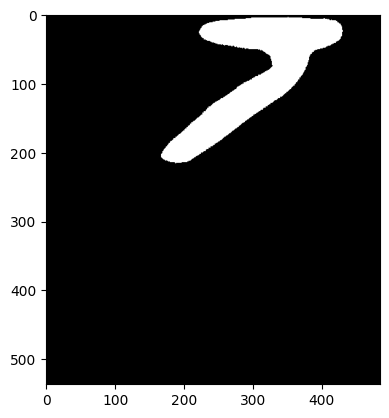

In [30]:
# you can have a look of some examples here
img = cv2.imread('/Users/amir/PycharmProjects/Medfair/MEDFAIR/BrEaST-Lesions_USG-images_and_masks/case001_tumor.png')
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Save images into pickle files
This is optional, but if you are training many models, this step can save a lot of time by reducing the data IO.

In [39]:
test_meta = pd.read_csv('/Users/amir/PycharmProjects/Medfair/MEDFAIR/split/new_train.csv')

path = '/Users/amir/PycharmProjects/Medfair/MEDFAIR/pkls/'
images = []
start = time.time()
for i in range(len(test_meta)):

    img = cv2.imread(path + test_meta.iloc[i]['Path'])
    # resize to the input size in advance to save time during training
    img = cv2.resize(img, (256, 256))
    images.append(img)
    
end = time.time()
end-start
with open(path + 'train_images.pkl', 'wb') as f:
    pickle.dump(images, f)

[ WARN:0@14811.699] global loadsave.cpp:241 findDecoder imread_('/Users/amir/PycharmProjects/Medfair/MEDFAIR/pkls//Users/amir/PycharmProjects/Medfair/MEDFAIR/BrEaST-Lesions_USG-images_and_masks/case001.png.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
